In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from operator import itemgetter
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from pprint import pprint

In [2]:
from constants import *
from utils import DirectoryManager, FileDownloader, prepare_data_using_feature_selection_and_vif
from models import *

c:\Users\Mahmoud\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\Mahmoud\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\Mahmoud\AppData\Local\Programs\Python\P

In [3]:
directory_manager = DirectoryManager("data")
file_downloader = FileDownloader(directory_manager)

file_downloader.download_files(urls_wget, urls_gdown)

All files are already downloaded


In [4]:
georgia_reciddf = pd.read_csv('data/georgia_recidivism.csv')
georgia_reciddf = georgia_reciddf.drop(columns="id") 

In [5]:
shape_dict = {
    "1_original shape": georgia_reciddf.shape,
    "2_count of null values": georgia_reciddf.isna().sum().sum(),
    "3_no. of duplicates": georgia_reciddf.duplicated().sum(),
    "4_shape after removing duplication and nan": georgia_reciddf.dropna().drop_duplicates().shape,
}
pprint(shape_dict)

{'1_original shape': (25835, 53),
 '2_count of null values': 36700,
 '3_no. of duplicates': 0,
 '4_shape after removing duplication and nan': (14170, 53)}


In [6]:
columns_with_nan = georgia_reciddf.columns[georgia_reciddf.isna().any()].tolist()
columns_with_nan

['gang_affiliated',
 'supervision_risk_score_first',
 'supervision_level_first',
 'prison_offense',
 'avg_days_per_drugtest',
 'drugtests_thc_positive',
 'drugtests_cocaine_positive',
 'drugtests_meth_positive',
 'drugtests_other_positive',
 'percent_days_employed',
 'jobs_per_year']

In [7]:
georgia_reciddf[columns_with_nan].isna().sum().sort_values(ascending=False)

avg_days_per_drugtest           6103
drugtests_thc_positive          5172
drugtests_cocaine_positive      5172
drugtests_meth_positive         5172
drugtests_other_positive        5172
prison_offense                  3277
gang_affiliated                 3167
supervision_level_first         1720
jobs_per_year                    808
supervision_risk_score_first     475
percent_days_employed            462
dtype: int64

In [8]:
columns_with_nan_numerical = georgia_reciddf[columns_with_nan].select_dtypes(include=[float, int]).columns.tolist()
columns_with_nan_categorical = georgia_reciddf[columns_with_nan].select_dtypes(include=[object, bool]).columns.tolist()

In [9]:
# imputer_numerical = SimpleImputer(strategy='mean')
# georgia_reciddf[columns_with_nan_numerical] = imputer_numerical.fit_transform(georgia_reciddf[columns_with_nan_numerical])

In [10]:
knn_imputer = KNNImputer(n_neighbors=5)  
georgia_reciddf[columns_with_nan_numerical] = knn_imputer.fit_transform(georgia_reciddf[columns_with_nan_numerical])

In [11]:
imputer_categorical = SimpleImputer(strategy='most_frequent')
georgia_reciddf[columns_with_nan_categorical] = imputer_categorical.fit_transform(georgia_reciddf[columns_with_nan_categorical])

In [12]:
georgia_reciddf["gang_affiliated"] = georgia_reciddf["gang_affiliated"].astype(int)

In [13]:
bool_features = georgia_reciddf.select_dtypes(include=bool).columns.tolist()

nominal_features = ['gender', 'prison_offense', 'race']

ordinal_features = ["age_at_release", "supervision_level_first",
                     "education_level", "dependents", "prison_years", "prior_arrest_episodes_felony",
                     "prior_arrest_episodes_misd", "prior_arrest_episodes_violent", "prior_arrest_episodes_property",
                     "prior_arrest_episodes_drug", "prior_arrest_episodes", "prior_conviction_episodes",
                     "prior_conviction_episodes_1", "prior_conviction_episodes_3", "prior_conviction_episodes_4",
                     "delinquency_reports", "program_attendances", "program_unexcusedabsences", "residence_changes"]

In [14]:
# Check if the combined set of nominal and ordinal features is the same to the set of object and bool columns in georgia_reciddf
set(nominal_features + ordinal_features) == set(georgia_reciddf.select_dtypes(include=object).columns)

True

# Outlier Removal

In [15]:
georgia_reciddf.select_dtypes(include=[int, float]).describe().loc[["mean", "std", "min", "max"], :]

,residence_puma,gang_affiliated,supervision_risk_score_first,avg_days_per_drugtest,drugtests_thc_positive,drugtests_cocaine_positive,drugtests_meth_positive,drugtests_other_positive,percent_days_employed,jobs_per_year,training_sample
mean,12.361796,0.152429,6.080720,93.404737,0.060132,0.014707,0.012699,0.007406,0.482969,0.759315,0.697813
std,7.133742,0.359443,2.363616,106.120703,0.125457,0.055997,0.055544,0.037325,0.422323,0.807640,0.459215
min,1.000000,0.000000,1.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,25.000000,1.000000,10.000000,1088.500000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,1.000000


<AxesSubplot:>

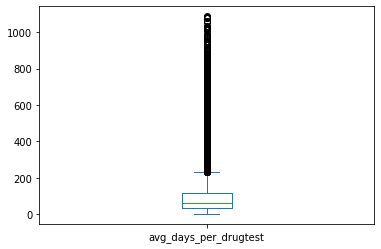

In [16]:
georgia_reciddf["avg_days_per_drugtest"].plot(kind="box")

In [17]:
col_with_outliers = georgia_reciddf["avg_days_per_drugtest"]

Q1 = col_with_outliers.quantile(0.25)
Q3 = col_with_outliers.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
lower_limit = Q1 - 1 * IQR
upper_limit = Q3 + 1 * IQR
georgia_reciddf = georgia_reciddf.drop(georgia_reciddf[(col_with_outliers <= lower_limit) | (col_with_outliers >= upper_limit)].index).reset_index(drop=True)

In [18]:
georgia_reciddf["avg_days_per_drugtest"].describe()

count    23427.000000
mean        67.244772
std         45.144303
min          0.500000
25%         31.263932
50%         55.869658
75%         95.873846
max        193.400000
Name: avg_days_per_drugtest, dtype: float64

<AxesSubplot:>

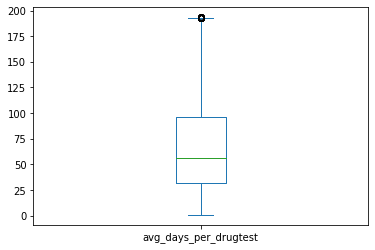

In [19]:
georgia_reciddf["avg_days_per_drugtest"].plot(kind="box")

<h1> Transformations

<h2> Bool Features

In [20]:
georgia_reciddf[bool_features] = georgia_reciddf[bool_features].astype(int)

<h2> Nominal Features

In [21]:
unique_nominal_dict = {}
for feature in nominal_features:
    unique_nominal_dict[feature] = georgia_reciddf[feature].unique().tolist()
pprint(unique_nominal_dict)

{'gender': ['M', 'F'],
 'prison_offense': ['Violent/Non-Sex',
                    'Drug',
                    'Property',
                    'Other',
                    'Violent/Sex'],
 'race': ['BLACK', 'WHITE']}


In [22]:
X = georgia_reciddf[nominal_features]

ohe = OneHotEncoder(drop='first')
feature_array, feature_labels = ohe.fit_transform(X), ohe.get_feature_names_out(input_features=X.columns)

df = pd.DataFrame(feature_array.toarray(), columns=feature_labels)
georgia_reciddf = georgia_reciddf.drop(columns=nominal_features)

georgia_reciddf = pd.concat([georgia_reciddf, df], axis=1)

<h2> Ordinal Features

In [23]:
unique_ordinal_dict = {}
for feature in ordinal_features:
    unique_ordinal_dict[feature] = georgia_reciddf[feature].unique().tolist()
pprint(unique_ordinal_dict)

{'age_at_release': ['33-37',
                    '48 or older',
                    '38-42',
                    '43-47',
                    '18-22',
                    '28-32',
                    '23-27'],
 'delinquency_reports': ['4 or more', '0', '3', '2', '1'],
 'dependents': ['1', '3 or more', '0', '2'],
 'education_level': ['Less than HS diploma',
                     'At least some college',
                     'High School Diploma'],
 'prior_arrest_episodes': ['5 or more', '3', '4', '1', '0', '2'],
 'prior_arrest_episodes_drug': ['3', '2', '1', '5 or more', '4', '0'],
 'prior_arrest_episodes_felony': ['7',
                                  '6',
                                  '8',
                                  '4',
                                  '10 or more',
                                  '3',
                                  '9',
                                  '2',
                                  '5',
                                  '1',
              

In [24]:
features_with_corresponding_order = {
    'education_level': ['Less than HS diploma', 'High School Diploma', 'At least some college'],
    'prison_years': ['1-2 years', 'Less than 1 year', 'Greater than 2 to 3 years', 'More than 3 years'],
    'supervision_level_first': ['Standard', 'High', 'Specialized'],
    'program_attendances': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10 or more'],
    'prior_arrest_episodes_felony': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10 or more']
}
for feature in ordinal_features:
    if not (feature in features_with_corresponding_order.keys()):
        features_with_corresponding_order[feature] = sorted(unique_ordinal_dict[feature], key=lambda x: int(x[0]))

pprint(features_with_corresponding_order)

{'age_at_release': ['18-22',
                    '28-32',
                    '23-27',
                    '33-37',
                    '38-42',
                    '48 or older',
                    '43-47'],
 'delinquency_reports': ['0', '1', '2', '3', '4 or more'],
 'dependents': ['0', '1', '2', '3 or more'],
 'education_level': ['Less than HS diploma',
                     'High School Diploma',
                     'At least some college'],
 'prior_arrest_episodes': ['0', '1', '2', '3', '4', '5 or more'],
 'prior_arrest_episodes_drug': ['0', '1', '2', '3', '4', '5 or more'],
 'prior_arrest_episodes_felony': ['0',
                                  '1',
                                  '2',
                                  '3',
                                  '4',
                                  '5',
                                  '6',
                                  '7',
                                  '8',
                                  '9',
                       

In [25]:
# Encoding Categorical Variables
for feature in ordinal_features:
    enc = OrdinalEncoder(categories=[features_with_corresponding_order[feature]])
    georgia_reciddf[[feature]] = enc.fit_transform(georgia_reciddf[[feature]])

## V) **Regression Analysis**

In [26]:
regression_columns = ['race_WHITE', 'age_at_release', 'gang_affiliated', 'prior_conviction_episodes',
                    'prior_conviction_episodes_1', 'prior_conviction_episodes_2',
                    'prior_conviction_episodes_3', 'prior_conviction_episodes_4',
                    'prior_conviction_episodes_5', 'prior_conviction_episodes_6',
                    'prior_conviction_episodes_7', 'supervision_risk_score_first']

df_regression = georgia_reciddf.copy()[regression_columns]

In [27]:
shape_dict = {
    "1_original shape": df_regression.shape,
    "2_count of null values": df_regression.isna().sum().sum(),
    "3_no. of duplicates": df_regression.duplicated().sum(),
    "4_shape after removing duplication and nan": df_regression.dropna().drop_duplicates().shape,
}
pprint(shape_dict)

{'1_original shape': (23427, 12),
 '2_count of null values': 0,
 '3_no. of duplicates': 6776,
 '4_shape after removing duplication and nan': (16651, 12)}


In [28]:
df_regression = df_regression.groupby(df_regression.columns.tolist(), as_index=False).mean()
df_regression.shape

(16651, 12)

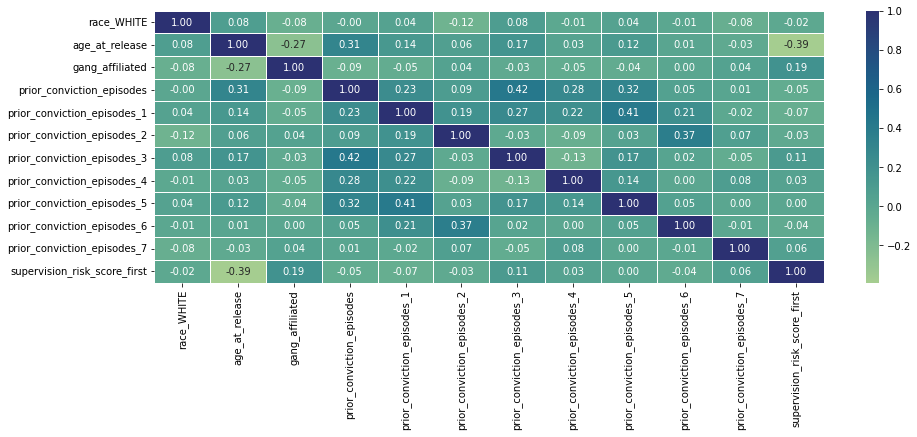

In [29]:
# Exploratory Data Analysis
plt.figure(figsize=(15, 5))
sns.heatmap(df_regression.corr(), annot=True, fmt=".2f", linewidth=.5, cmap="crest");

In [30]:
# Model Fitting
X, y = df_regression.drop('supervision_risk_score_first', axis=1), df_regression['supervision_risk_score_first']

# Standardizing the data using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Linear regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predictions
y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)

# Model evaluation
print("Training R2:", r2_score(y_train, y_train_pred))
print("Test R2:", r2_score(y_test, y_test_pred))

Training R2: 0.20883811732406188
Test R2: 0.21948781060007738


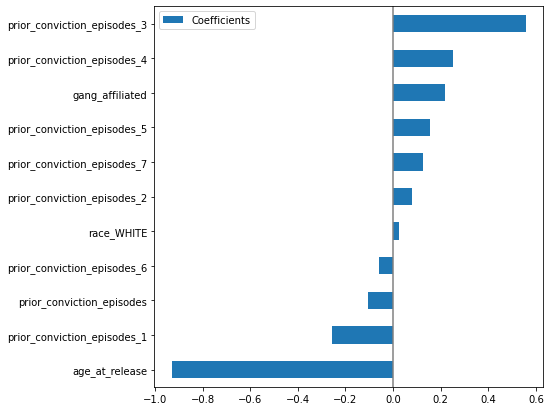

In [31]:
coefs = pd.DataFrame(
    linear_model.coef_, columns=["Coefficients"], index=X.columns
).sort_values(by="Coefficients")

coefs.plot(kind="barh", figsize=(9, 7))
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

# VI) ML clf

In [32]:
# Combine Data Preprocessing Steps
X, y = georgia_reciddf.drop(columns='recidivism_within_3years'), georgia_reciddf['recidivism_within_3years']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [33]:
# Check for imbalance in the training, and test sets
print("Class distribution in training set:")
print(y_train.value_counts(normalize=True))
print()
print("Class distribution in test set:")
print(y_test.value_counts(normalize=True))

Class distribution in training set:
recidivism_within_3years
1    0.574783
0    0.425217
Name: proportion, dtype: float64

Class distribution in test set:
recidivism_within_3years
1    0.576398
0    0.423602
Name: proportion, dtype: float64


In [34]:
# Baseline
baseline = y.value_counts(normalize=True).max()
print(f"Baseline: {baseline * 100:.2f}%")

Baseline: 57.51%


<h5> The dataset is relatively balanced

The following models don't use feature selection methods, but use dimensionality Reduction techniques PCA, UMAP.

In [37]:
# load the model from disk
filename = "Models/Model_1.sav"
loaded_model = pickle.load(open(filename, 'rb'))

best_params = loaded_model.best_params_

# Use the best estimator to make predictions on the training set
y_train_pred = loaded_model.best_estimator_.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)

# Predict on the test set using the best parameters
y_pred_test = loaded_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)

print("Best Parameters: ", best_params)
print("Accuracy on the training set: ", accuracy_train)
print("Accuracy on the test set: ", accuracy_test)

Best Parameters:  {'pca__n_components': 20, 'classifier__n_estimators': 100, 'classifier__min_samples_split': 5, 'classifier__max_depth': 30}
Accuracy on the training set:  0.9994664105437276
Accuracy on the test set:  0.9741784037558685


In [38]:
# Confusion matrix on the test set
other_metrics = {
    "1_Confusion Matrix": list(confusion_matrix(y_test, y_pred_test)),
    "2_Precision": precision_score(y_test, y_pred_test),
    "3_Recall": recall_score(y_test, y_pred_test),
    "4_AUC-ROC Score": roc_auc_score(y_test, loaded_model.best_estimator_.predict_proba(X_test)[:, 1])
}
pprint(other_metrics)

{'1_Confusion Matrix': [array([1900,   85], dtype=int64),
                        array([  36, 2665], dtype=int64)],
 '2_Precision': 0.9690909090909091,
 '3_Recall': 0.9866716031099593,
 '4_AUC-ROC Score': 0.997385239350665}


In [45]:
# Load the model from the file
with open("Models/Model_2.sav", "rb") as file:
    model_2 = pickle.load(file)

best_params = model_2.best_params_

# Use the best estimator to make predictions on the training set
y_train_pred = model_2.best_estimator_.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)

# Predict on the test set using the best parameters
y_pred_test = model_2.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)

print("Best Parameters: ")
pprint(best_params)
print("Accuracy on the training set: ", accuracy_train)
print("Accuracy on the test set: ", accuracy_test)

Best Parameters: 
{'classifier__max_depth': 20,
 'classifier__n_estimators': 5,
 'pca__n_components': 20}
Accuracy on the training set:  0.9995197694893548
Accuracy on the test set:  0.9408877507469057


In [48]:
# Load the model from the file
with open("Models/Model_3.sav", "rb") as file:
    model_3 = pickle.load(file)

best_params = model_3.best_params_

# Use the best estimator to make predictions on the training set
y_train_pred = model_3.best_estimator_.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)

# Predict on the test set using the best parameters
y_pred_test = model_3.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)

print("Best Parameters: ")
pprint(best_params)
print("Accuracy on the training set: ", accuracy_train)
print("Accuracy on the test set: ", accuracy_test)

Best Parameters: 
{'classifier__max_depth': 20,
 'classifier__min_samples_split': 2,
 'umap__n_components': 20,
 'umap__n_neighbors': 30}
Accuracy on the training set:  1.0
Accuracy on the test set:  0.9850618864703372


The following models use Feature Selection methods

In [41]:
X_train, X_test, y_train, y_test = prepare_data_using_feature_selection_and_vif(X, y)

In [42]:
accuracy_train, cv_scores = model_4(X_train, X_test, y_train, y_test)
print("Training Accuracy:", accuracy_train)
print("Average Cross-Validation Accuracy for test data:", cv_scores.mean())

Training Accuracy: 0.9926364655034416
Average Cross-Validation Accuracy for test data: 0.9944519664218927


In [43]:
accuracy_train, cv_scores = model_5(X_train, X_test, y_train, y_test)
print("Training Accuracy:", accuracy_train)
print("Average Cross-Validation Accuracy for test data:", cv_scores.mean())

Training Accuracy: 1.0
Average Cross-Validation Accuracy for test data: 1.0
